In [1]:
import zipfile
from glob import glob
import os
from netCDF4 import Dataset
import pandas as pd
import geopandas as gpd # GeoPandas(지오판다스)
from shapely.geometry import Polygon, LineString, Point
path = os.getcwd()

import rasterio
from rasterio.plot import show
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

import numpy as np

import requests
import time

from geocube.api.core import make_geocube
import seaborn as sns

from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
print(device_lib.list_local_devices())

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 632623119548115200
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3645898752
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3029332595062691350
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
path

'c:\\Users\\Go\\OneDrive - UOS\\allrepos\\UNet-project (2)'

## 데이터셋 생성

* 데이터셋 window 설정 점검

In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _parse_function(tfrecord_serialized):
    features={
        'CMAQ_t': tf.io.FixedLenFeature([], tf.string),
        'SMOKE_t': tf.io.FixedLenFeature([], tf.string),
        'air_quality_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        'weather_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        'year': tf.io.FixedLenFeature([], tf.string),
        'month': tf.io.FixedLenFeature([], tf.string),
        'day': tf.io.FixedLenFeature([], tf.string),
        'hour': tf.io.FixedLenFeature([], tf.string),
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    cmaq = tf.io.decode_raw(parsed_features['CMAQ_t'], tf.float32)
    smoke = tf.io.decode_raw(parsed_features['SMOKE_t'], tf.float32)
    aq = tf.io.decode_raw(parsed_features['air_quality_monitoring_t'], tf.float64)  #이것 둘 64로 저장됨
    weather = tf.io.decode_raw(parsed_features['weather_monitoring_t'], tf.float64)
    year = tf.io.decode_raw(parsed_features['year'], tf.uint8)
    month = tf.io.decode_raw(parsed_features['month'], tf.uint8)
    day = tf.io.decode_raw(parsed_features['day'], tf.uint8)
    hour = tf.io.decode_raw(parsed_features['hour'], tf.uint8)

  

    cmaq = tf.reshape(cmaq, [82, 67, 1])
    print(cmaq.shape)
    smoke = tf.reshape(smoke, [82, 67, 45])
    print(smoke.shape)
    aq = tf.reshape(aq, [82, 67, 1])
    print(aq.shape)
    weather = tf.reshape(weather, [82, 67, 15])
    print(weather.shape)
    
    year = tf.squeeze(year)
    month = tf.squeeze(month)
    day = tf.squeeze(day)
    hour = tf.squeeze(hour)

    
    # image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    # image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])


    # classes = tf.io.decode_raw(parsed_features['classes'], tf.uint8)    
    # classes = tf.squeeze(classes)
    tf.cast(cmaq,tf.float32)

    return cmaq, smoke, aq, weather, year, month, day, hour

In [136]:
BATCH_SIZE = 5
window_size = 5
shift = 1
# exam_dataset = tf.data.TFRecordDataset(os.path.join("e:",'dataset_105.tfr'))
# exam_dataset = tf.data.TFRecordDataset([os.path.join(path,"dataset_record",'dataset_105.tfr'),os.path.join(path,"dataset_record",'dataset_106.tfr'),])
exam_dataset = tf.data.TFRecordDataset(os.path.join(path,"dataset_record",'dataset_105.tfr'))
exam_dataset = exam_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# exam_dataset = exam_dataset.prefetch(tf.data.experimental.AUTOTUNE).window(5, shift=1, drop_remainder = True).batch(BATCH_SIZE)
exam_dataset = exam_dataset.prefetch(tf.data.experimental.AUTOTUNE).window(window_size, shift=shift, drop_remainder = True)
# exam_dataset = exam_dataset.flat_map(lambda window: window.batch(input_width))
def get_cmaq_window(x1,x2,x3,x4,x5,x6,x7,x8,):
    return x1.batch(window_size, drop_remainder=True)

def get_smoke_window(x1,x2,x3,x4,x5,x6,x7,x8,):
    return x2.batch(window_size, drop_remainder=True)

def get_time_window(x1,x2,x3,x4,x5,x6,x7,x8,):
    return x8.batch(window_size, drop_remainder=True)

def dense_step_input(input_batch):
  # Shift features and labels one step relative to each other.
  return input_batch[:-1]

def dense_step_target(target_batch):
  # Shift features and labels one step relative to each other.
  return target_batch[-1:]



exam_dataset_cmaq = exam_dataset.flat_map(get_cmaq_window)
target_cmaq = exam_dataset_cmaq.map(dense_step_target)

exam_dataset_smoke = exam_dataset.flat_map(get_smoke_window)
input_smoke = exam_dataset_cmaq.map(dense_step_input)

exam_dataset_smoke_time = exam_dataset.flat_map(get_time_window)
input_smoke_time = exam_dataset_smoke_time.map(dense_step_input)

exam_dataset_cmaq_time = exam_dataset.flat_map(get_time_window)
target_cmaq_time = exam_dataset_cmaq_time.map(dense_step_target)


(82, 67, 1)
(82, 67, 45)
(82, 67, 1)
(82, 67, 15)


In [137]:
for example in target_cmaq.take(5):
  print(example.shape)


(1, 82, 67, 1)
(1, 82, 67, 1)
(1, 82, 67, 1)
(1, 82, 67, 1)
(1, 82, 67, 1)


In [138]:
for example in input_smoke.take(5):
  print(example.shape)

(4, 82, 67, 1)
(4, 82, 67, 1)
(4, 82, 67, 1)
(4, 82, 67, 1)
(4, 82, 67, 1)


In [141]:
for example in input_smoke_time.take(5):
  print(example)

tf.Tensor(
[[0 0 0 0]
 [1 0 0 0]
 [2 0 0 0]
 [3 0 0 0]], shape=(4, 4), dtype=uint8)
tf.Tensor(
[[1 0 0 0]
 [2 0 0 0]
 [3 0 0 0]
 [4 0 0 0]], shape=(4, 4), dtype=uint8)
tf.Tensor(
[[2 0 0 0]
 [3 0 0 0]
 [4 0 0 0]
 [5 0 0 0]], shape=(4, 4), dtype=uint8)
tf.Tensor(
[[3 0 0 0]
 [4 0 0 0]
 [5 0 0 0]
 [6 0 0 0]], shape=(4, 4), dtype=uint8)
tf.Tensor(
[[4 0 0 0]
 [5 0 0 0]
 [6 0 0 0]
 [7 0 0 0]], shape=(4, 4), dtype=uint8)


In [142]:
for example in target_cmaq_time.take(5):
  print(example)

tf.Tensor([[4 0 0 0]], shape=(1, 4), dtype=uint8)
tf.Tensor([[5 0 0 0]], shape=(1, 4), dtype=uint8)
tf.Tensor([[6 0 0 0]], shape=(1, 4), dtype=uint8)
tf.Tensor([[7 0 0 0]], shape=(1, 4), dtype=uint8)
tf.Tensor([[8 0 0 0]], shape=(1, 4), dtype=uint8)


In [143]:
zip_ds = tf.data.Dataset.zip((input_smoke_time, target_cmaq_time))

In [144]:
for exam in zip_ds.batch(5).take(1):
    break

In [146]:
exam[0]

<tf.Tensor: shape=(5, 4, 4), dtype=uint8, numpy=
array([[[0, 0, 0, 0],
        [1, 0, 0, 0],
        [2, 0, 0, 0],
        [3, 0, 0, 0]],

       [[1, 0, 0, 0],
        [2, 0, 0, 0],
        [3, 0, 0, 0],
        [4, 0, 0, 0]],

       [[2, 0, 0, 0],
        [3, 0, 0, 0],
        [4, 0, 0, 0],
        [5, 0, 0, 0]],

       [[3, 0, 0, 0],
        [4, 0, 0, 0],
        [5, 0, 0, 0],
        [6, 0, 0, 0]],

       [[4, 0, 0, 0],
        [5, 0, 0, 0],
        [6, 0, 0, 0],
        [7, 0, 0, 0]]], dtype=uint8)>

In [147]:
exam[1]

<tf.Tensor: shape=(5, 1, 4), dtype=uint8, numpy=
array([[[4, 0, 0, 0]],

       [[5, 0, 0, 0]],

       [[6, 0, 0, 0]],

       [[7, 0, 0, 0]],

       [[8, 0, 0, 0]]], dtype=uint8)>

* 학습-검증셋 준비

In [3]:
def _parse_function2(tfrecord_serialized):
    features={
        'CMAQ_t': tf.io.FixedLenFeature([], tf.string),
        'SMOKE_t': tf.io.FixedLenFeature([], tf.string),
        'air_quality_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        'weather_monitoring_t': tf.io.FixedLenFeature([], tf.string),
        # 'year': tf.io.FixedLenFeature([], tf.string),
        # 'month': tf.io.FixedLenFeature([], tf.string),
        # 'day': tf.io.FixedLenFeature([], tf.string),
        # 'hour': tf.io.FixedLenFeature([], tf.string),
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    cmaq = tf.io.decode_raw(parsed_features['CMAQ_t'], tf.float32)
    # 12년 측정망자료로 나중에 정규화 해주기
    smoke = tf.io.decode_raw(parsed_features['SMOKE_t'], tf.float32)
    aq = tf.io.decode_raw(parsed_features['air_quality_monitoring_t'], tf.float64)  #이것 둘 64로 저장됨
    # 바람 방향 x, y벡터랑 강도로 뽑는작업 나중에 하기
    weather = tf.io.decode_raw(parsed_features['weather_monitoring_t'], tf.float64)
    # year = tf.io.decode_raw(parsed_features['year'], tf.uint8)
    # 월 sin함수 주기로 바꾸어서 넣어주기
    # month = tf.io.decode_raw(parsed_features['month'], tf.uint8)
    # 일 sin함수 주기로 바꾸어서 넣어주기
    # day = tf.io.decode_raw(parsed_features['day'], tf.uint8)
    # hour = tf.io.decode_raw(parsed_features['hour'], tf.uint8)

  

    cmaq = tf.reshape(cmaq, [82, 67, 1])
    # print(cmaq.shape)
    smoke = tf.reshape(smoke, [82, 67, 45])
    # print(smoke.shape)
    aq = tf.reshape(aq, [82, 67, 1])
    # # print(aq.shape)
    weather = tf.reshape(weather, [82, 67, 15])
    # print(weather.shape)
    
    # year = tf.squeeze(year)
    # month = tf.squeeze(month)
    # day = tf.squeeze(day)
    # hour = tf.squeeze(hour)

    
    # image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    # image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])


    # classes = tf.io.decode_raw(parsed_features['classes'], tf.uint8)    
    # classes = tf.squeeze(classes)
    # tf.cast(cmaq,tf.float32)
    # tf.concat([tf.cast(smoke,tf.float32),tf.cast(aq,tf.float32),tf.cast(weather,tf.float32),], axis=3)
    # tf.concat([tf.cast(smoke,tf.float32),tf.cast(aq,tf.float32),tf.cast(weather,tf.float32),], axis=2)[8:-10,2:-1,:]
    # return cmaq[8:-10,2:-1,:], tf.cast(smoke,tf.float32)[8:-10,2:-1,:], year, month, day, hour
    # return smoke[8:-10,2:-1,:],cmaq[8:-10,2:-1,:]
    # return smoke,cmaq
    return tf.concat([tf.cast(smoke,tf.float32),tf.cast(aq,tf.float32),tf.cast(weather,tf.float32),], axis=2)[8:-10,2:-1,:], cmaq[8:-10,2:-1,:]

In [4]:
all_tfr_path = glob(os.path.join(path,"dataset_record",'*.tfr'))
train_len = round(len(all_tfr_path) * 0.8)

train_tfr_path = list(np.random.choice(all_tfr_path,train_len, replace=False))

test_tfr_path = list(set(all_tfr_path) - set(train_tfr_path))
val_tfr_path = list(np.random.choice(test_tfr_path,1, replace=False))
test_tfr_path = list(set(test_tfr_path) - set(val_tfr_path))

print("trainset_n: ", train_len, "valset_n: ", len(val_tfr_path), "testset_n: ", len(test_tfr_path))

trainset_n:  6 valset_n:  1 testset_n:  0


In [5]:
BATCH_SIZE = 4
EPOCH = 1
# N_RUN = 1000

input_width = 6
target_width = 1
window_size = input_width + target_width
shift = 1

def get_target_window(x1,x2):
    return x2.batch(window_size, drop_remainder=True)

def get_input_window(x1,x2):
    return x1.batch(window_size, drop_remainder=True)

def dense_step_input(input_batch):
  # Shift features and labels one step relative to each other.
  return input_batch[:-1]

def dense_step_target(target_batch):
  # Shift features and labels one step relative to each other.
  return target_batch[-1]

In [6]:
# 학습셋, 셔플 x일단, 정규화도 x 나중에 12년도 데이터 사용해서 스케일링할것
train_dataset = tf.data.TFRecordDataset(train_tfr_path)
train_dataset = train_dataset.map(_parse_function2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE).window(window_size, shift=shift, drop_remainder = True)

train_dataset_cmaq = train_dataset.flat_map(get_target_window)
train_target = train_dataset_cmaq.map(dense_step_target)

train_dataset_smoke = train_dataset.flat_map(get_input_window)
train_input = train_dataset_smoke.map(dense_step_input)

train_ds = tf.data.Dataset.zip((train_input, train_target)).batch(BATCH_SIZE).shuffle(1000)

In [7]:
# 검증셋, 셔플 x일단, 정규화도 x 나중에 12년도 데이터 사용해서 스케일링할것
val_dataset = tf.data.TFRecordDataset(val_tfr_path)
val_dataset = val_dataset.map(_parse_function2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE).window(window_size, shift=shift, drop_remainder = True)

val_dataset_cmaq = val_dataset.flat_map(get_target_window)
val_target = val_dataset_cmaq.map(dense_step_target)

val_dataset_smoke = val_dataset.flat_map(get_input_window)
val_input = val_dataset_smoke.map(dense_step_input)

val_ds = tf.data.Dataset.zip((val_input, val_target)).batch(BATCH_SIZE).shuffle(1000)

In [10]:
# # 검증셋, 셔플 x일단, 정규화도 x 나중에 12년도 데이터 사용해서 스케일링할것
# test_dataset = tf.data.TFRecordDataset(test_tfr_path)
# test_dataset = test_dataset.map(_parse_function2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE).window(window_size, shift=shift, drop_remainder = True)

# test_dataset_cmaq = test_dataset.flat_map(get_target_window)
# test_target = test_dataset_cmaq.map(dense_step_target)

# test_dataset_smoke = test_dataset.flat_map(get_input_window)
# test_input = test_dataset_smoke.map(dense_step_input)

# test_ds = tf.data.Dataset.zip((test_input, test_target)).batch(BATCH_SIZE).shuffle(1000)

## 모델 학습

In [62]:
#################### CHECK !! ######################
####################################################
#인풋채널수 잘 확인

INPUT_SHAPE = [input_width, 64, 64, 61]
OUTPUT_CHANNELS = 1

In [63]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():

  inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

  initializer_1 = tf.random_normal_initializer(0., 0.02)
  conv_lstm2d = tf.keras.layers.ConvLSTM2D(32, kernel_size=3, padding='same', return_sequences=False, kernel_initializer=initializer_1)
  batch_norm_1 = tf.keras.layers.BatchNormalization()
  relu_1 = tf.keras.layers.ReLU()

  down_stack = [
    downsample(64, 3),  # (batch_size, 64, 64, 64)
    downsample(128, 3),  # (batch_size, 32, 32, 128)
    downsample(256, 3),  # (batch_size, 16, 16, 256)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 3),  # (batch_size, 4, 4, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3),  # (batch_size, 8, 8, 1024)
    upsample(256, 3),  # (batch_size, 16, 16, 512)
    upsample(128, 3),  # (batch_size, 32, 32, 256)
    upsample(64, 3),  # (batch_size, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         )  # (batch_size, 256, 256, 3)  activation='tanh'

  x = inputs
  x = conv_lstm2d(x)
  
  x = batch_norm_1(x)
  x = relu_1(x)
  
  # x = data_augmentation(x)      

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [64]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [65]:
def Discriminator():
  conv_lstm2d = tf.keras.layers.ConvLSTM2D(1, kernel_size=3, padding='same', return_sequences=False, )
  
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=INPUT_SHAPE, name='input_image')
  tar = tf.keras.layers.Input(shape=[64, 64,1], name='target_image')

  inp_1 = conv_lstm2d(inp)

  print(inp_1)
  print(tar)

  x = tf.keras.layers.concatenate([inp_1, tar])  # (batch_size, 256, 256, channels*2)
  print(x)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
  print(last)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [66]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [74]:
## 저장된 모델 불러오기
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

generator = Generator()
discriminator = Discriminator()


checkpoint_dir = os.path.join(path,'training_checkpoints',"model_ver4_checkpoint")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None), name='conv_lstm2d_5/strided_slice_2:0', description="created by layer 'conv_lstm2d_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name='target_image'), name='target_image', description="created by layer 'target_image'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 2), dtype=tf.float32, name=None), name='concatenate_39/concat:0', description="created by layer 'concatenate_39'")
KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 1), dtype=tf.float32, name=None), name='conv2d_71/BiasAdd:0', description="created by layer 'conv2d_71'")


In [75]:
checkpoint_prefix

'c:\\Users\\Go\\OneDrive - UOS\\allrepos\\UNet-project (2)\\training_checkpoints\\model_ver4_checkpoint\\ckpt'

In [68]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))
  display_list = [test_input[0][0][:,:,:3][::-1], tar[0][:,:,0][::-1], prediction[0][::-1]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [69]:
for batch in val_ds.take(1):
    print(1)

1


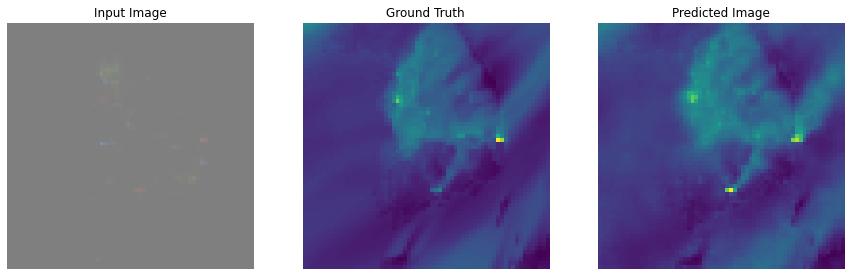

In [70]:
generate_images(generator, batch[0][0:1], batch[1][0:1])

## 불러온 모델 점검

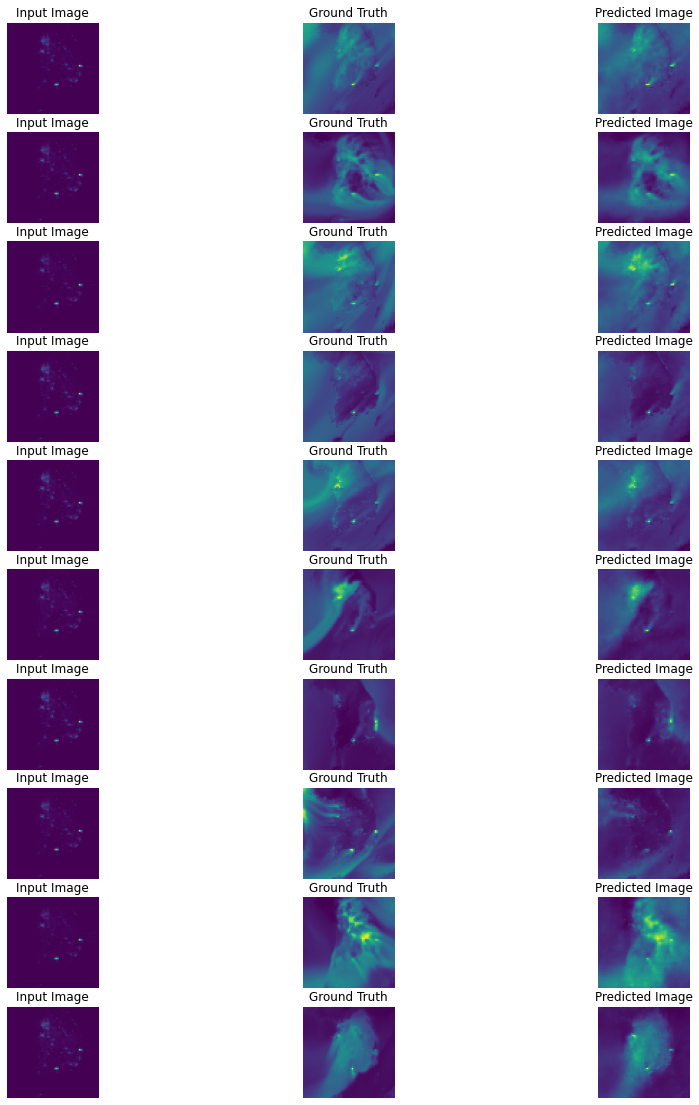

In [71]:
plt.figure(figsize=(15, 15*4))
j = 0
for step, (input_image, target) in val_ds.repeat().take(10).enumerate():
  prediction = generator(input_image, training=True)
  
  display_list = [input_image[3][0][:,:,0][::-1], target[3][:,:,0][::-1], prediction[3][:,:,0][::-1]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  for i in range(3):
    plt.subplot(30, 3, j + i + 1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
  j += 3

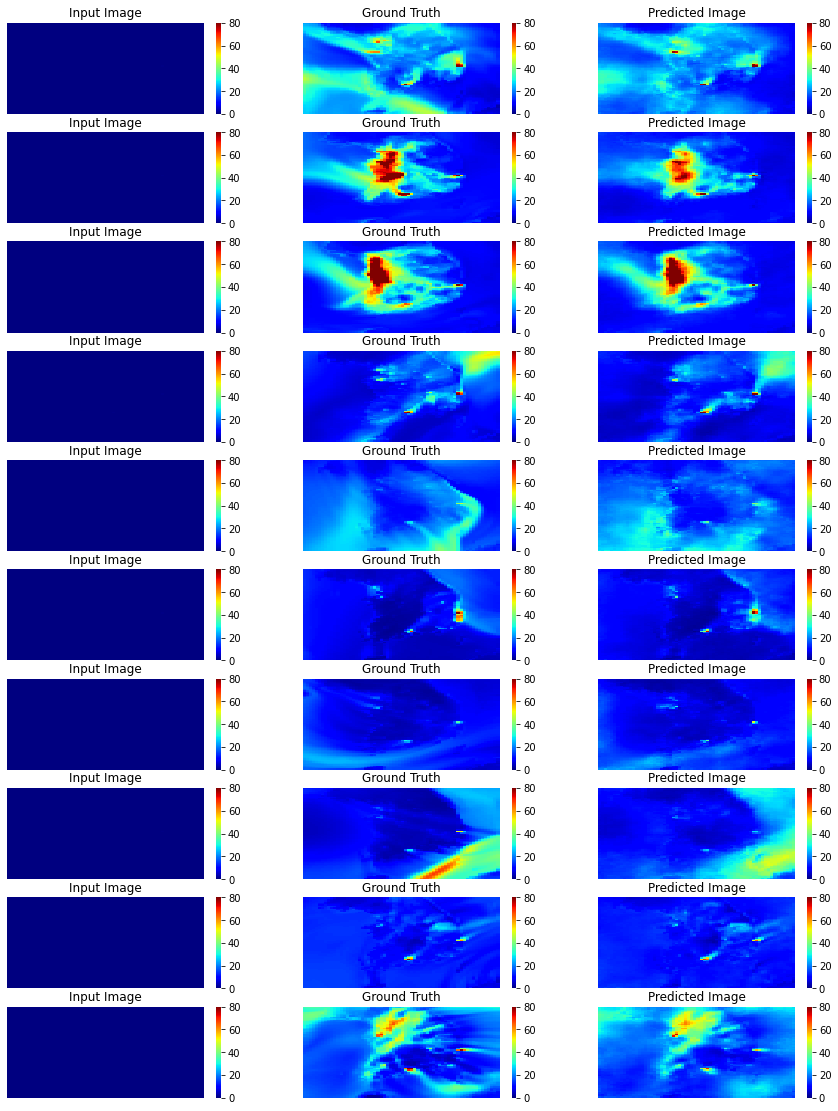

In [72]:
plt.figure(figsize=(15, 15*4))
j = 0
for step, (input_image, target) in val_ds.repeat().take(10).enumerate():
  prediction = generator(input_image, training=True)
  
  display_list = [input_image[3][0][:,:,0][::-1], target[3][:,:,0][::-1], prediction[3][:,:,0][::-1]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  for i in range(3):
    plt.subplot(30, 3, j + i + 1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    sns.heatmap(display_list[i], cmap='jet', vmax=80, vmin=0)
    plt.axis('off')
  j += 3

## 추가학습

In [80]:
import datetime

checkpoint_dir_5 = os.path.join(path,'training_checkpoints',"model_ver5_checkpoint")
checkpoint_prefix_5 = os.path.join(checkpoint_dir_5, "ckpt")


log_dir=os.path.join(checkpoint_dir_5,"logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
summary_writer = tf.summary.create_file_writer(log_dir)

In [81]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step)
    tf.summary.scalar('disc_loss', disc_loss, step=step)

In [82]:
from IPython import display

In [ ]:
steps = 50000

example_input, example_target = next(iter(val_ds.take(1)))
start = time.time()

for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
  if (step) % 200 == 0:
    display.clear_output(wait=True)

    if step != 0:
      print(f'Time taken for 200 steps: {time.time()-start:.2f} sec\n')

    start = time.time()

    generate_images(generator, example_input, example_target)
    print(f"Step: {step}")

  train_step(input_image, target, step)

  # Training step
  if (step+1) % 100 == 0:
    print('.', end='', flush=True)


  # Save (checkpoint) the model every 5k steps
  if (step + 1) % 1000 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix_5)

* train-test 섞는 중 랜덤으로 몇번 돌리느라 leakage 일어난듯..., 미리 분리해야겠음

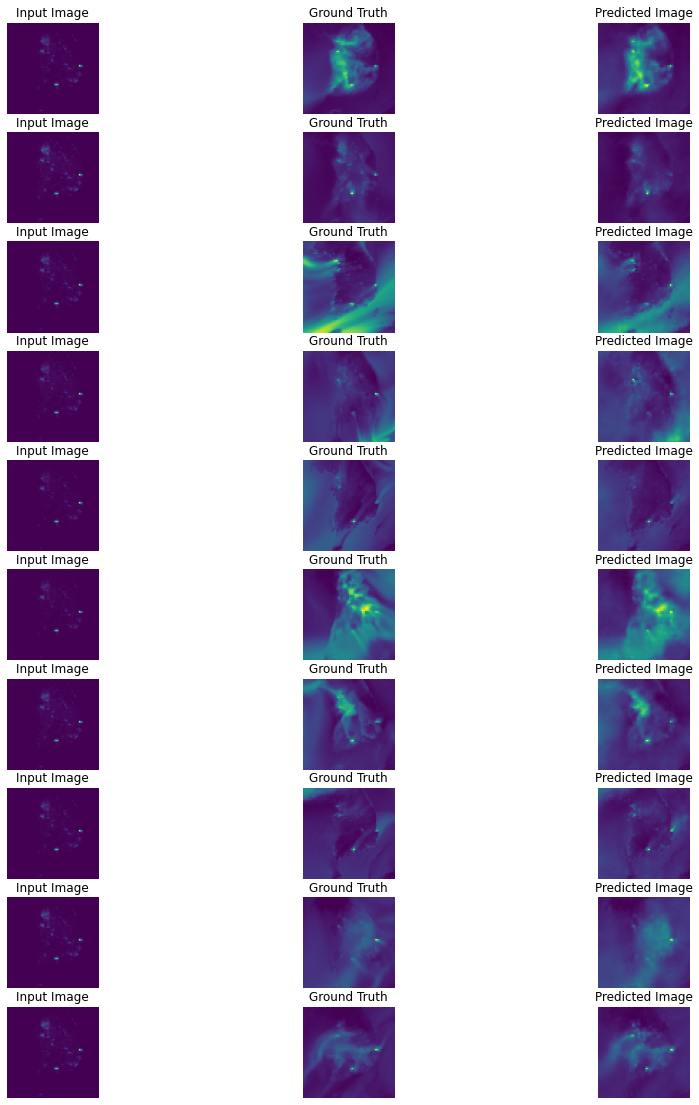

In [84]:
plt.figure(figsize=(15, 15*4))
j = 0
for step, (input_image, target) in val_ds.repeat().take(10).enumerate():
  prediction = generator(input_image, training=True)
  
  display_list = [input_image[3][0][:,:,0][::-1], target[3][:,:,0][::-1], prediction[3][:,:,0][::-1]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  for i in range(3):
    plt.subplot(30, 3, j + i + 1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
  j += 3

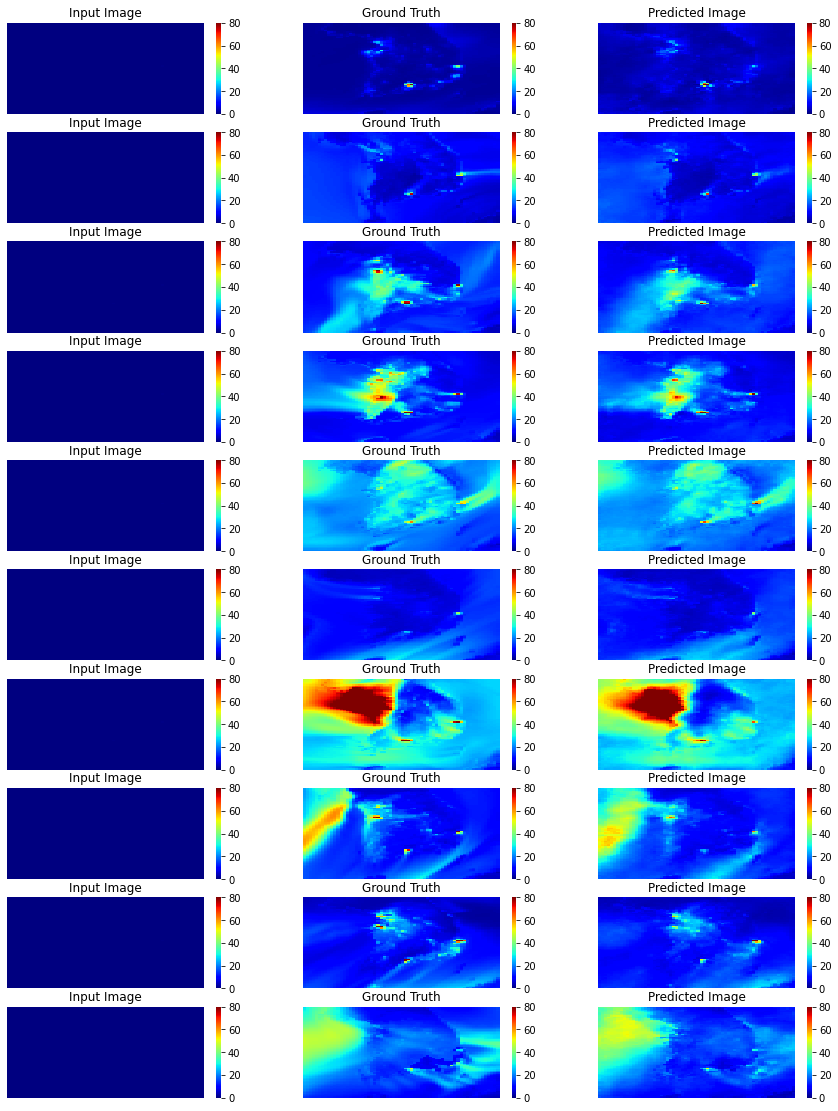

In [85]:
plt.figure(figsize=(15, 15*4))
j = 0
for step, (input_image, target) in val_ds.repeat().take(10).enumerate():
  prediction = generator(input_image, training=True)
  
  display_list = [input_image[3][0][:,:,0][::-1], target[3][:,:,0][::-1], prediction[3][:,:,0][::-1]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  for i in range(3):
    plt.subplot(30, 3, j + i + 1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    sns.heatmap(display_list[i], cmap='jet', vmax=80, vmin=0)
    plt.axis('off')
  j += 3

* 노이즈 약간 추가

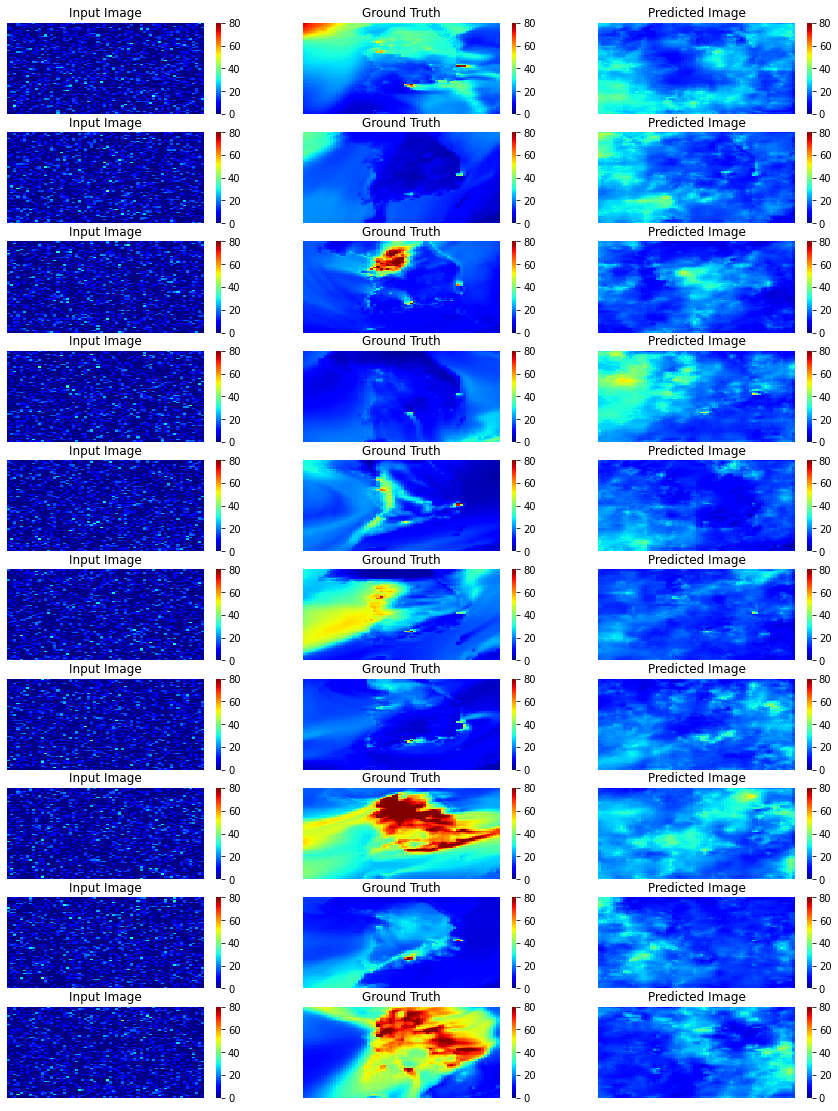

In [101]:
plt.figure(figsize=(15, 15*4))
j = 0
for step, (input_image, target) in val_ds.repeat().take(10).enumerate():
  noise_layer = tf.keras.layers.GaussianNoise(   # 노이즈레이어 이부분도 학습에서만 활성화됨
        10, seed=None
    )
  noise_input_image = noise_layer(input_image,training = True)
  prediction = generator(noise_input_image, training=True)
  
  display_list = [noise_input_image[3][0][:,:,0][::-1], target[3][:,:,0][::-1], prediction[3][:,:,0][::-1]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  for i in range(3):
    plt.subplot(30, 3, j + i + 1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    sns.heatmap(display_list[i], cmap='jet', vmax=80, vmin=0)
    plt.axis('off')
  j += 3

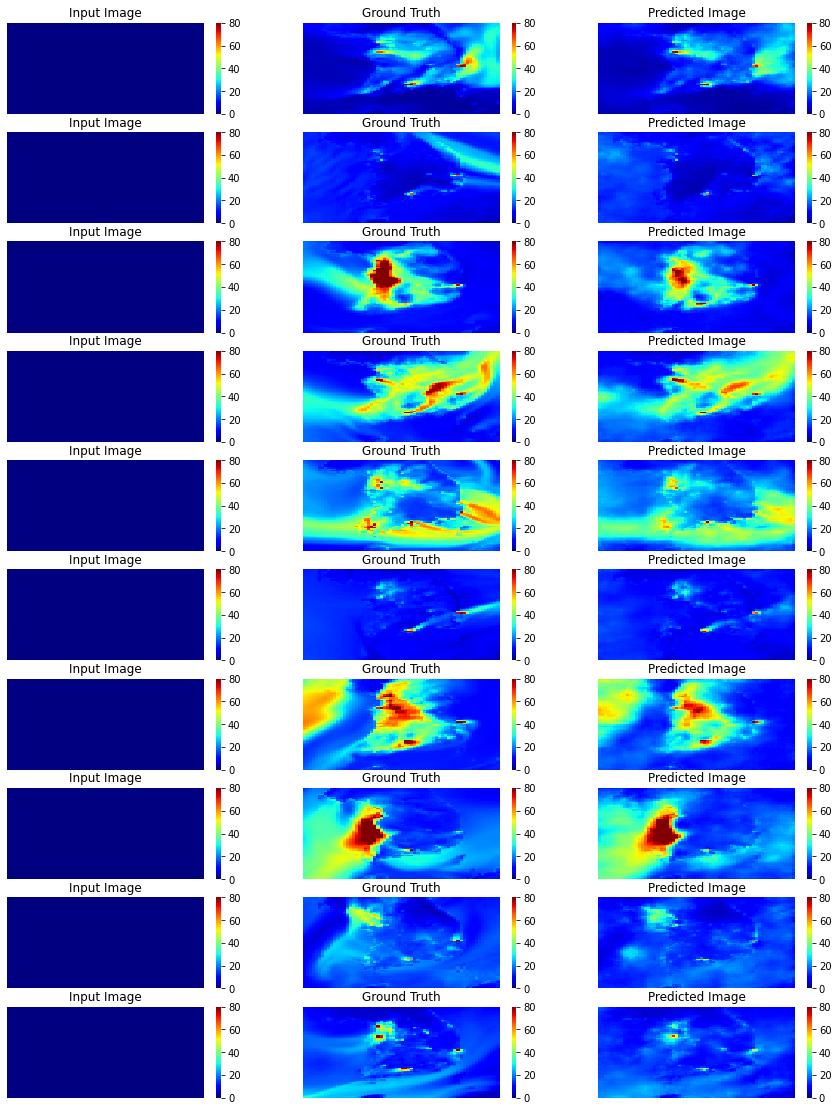

In [103]:
plt.figure(figsize=(15, 15*4))
j = 0
for step, (input_image, target) in val_ds.repeat().take(10).enumerate():
  noise_layer = tf.keras.layers.GaussianNoise(   # 노이즈레이어 이부분도 학습에서만 활성화됨
        0.1, seed=None
    )
  noise_input_image = noise_layer(input_image,training = True)
  prediction = generator(noise_input_image, training=True)
  
  display_list = [noise_input_image[3][0][:,:,0][::-1], target[3][:,:,0][::-1], prediction[3][:,:,0][::-1]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  for i in range(3):
    plt.subplot(30, 3, j + i + 1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    sns.heatmap(display_list[i], cmap='jet', vmax=80, vmin=0)
    plt.axis('off')
  j += 3

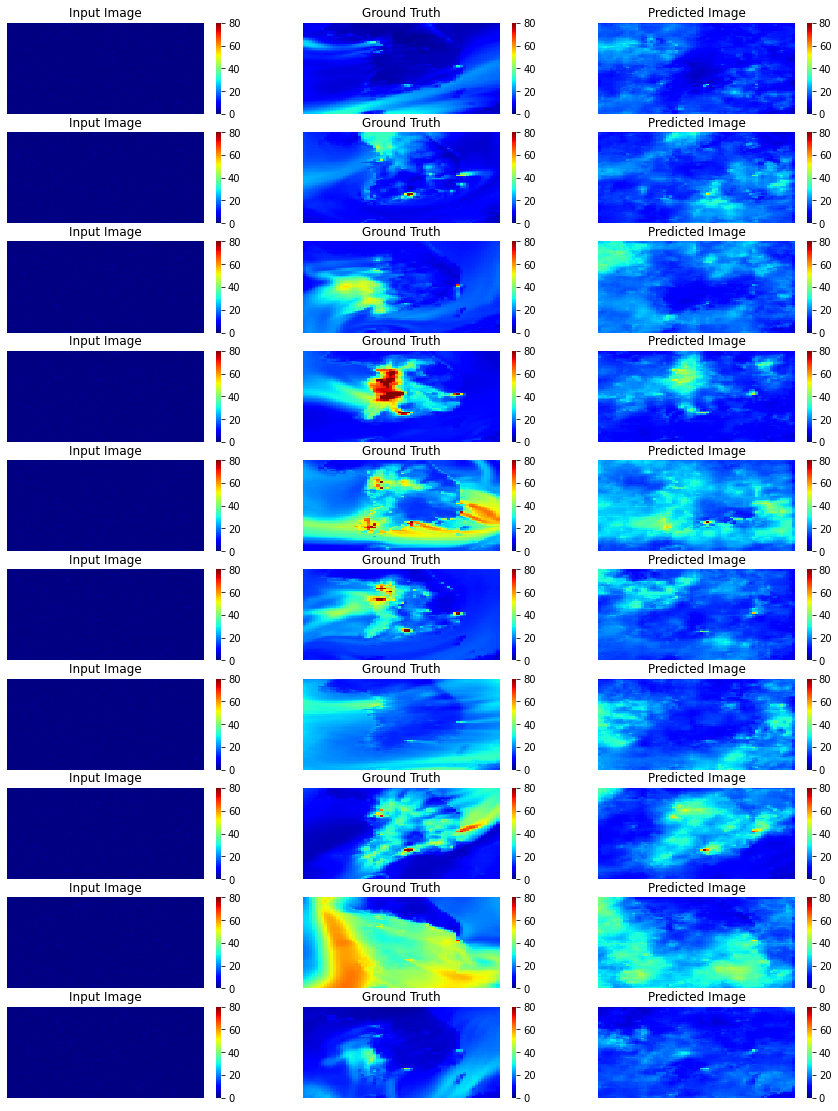

In [104]:
plt.figure(figsize=(15, 15*4))
j = 0
for step, (input_image, target) in val_ds.repeat().take(10).enumerate():
  noise_layer = tf.keras.layers.GaussianNoise(   # 노이즈레이어 이부분도 학습에서만 활성화됨
        0.5, seed=None
    )
  noise_input_image = noise_layer(input_image,training = True)
  prediction = generator(noise_input_image, training=True)
  
  display_list = [noise_input_image[3][0][:,:,0][::-1], target[3][:,:,0][::-1], prediction[3][:,:,0][::-1]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  
  for i in range(3):
    plt.subplot(30, 3, j + i + 1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    sns.heatmap(display_list[i], cmap='jet', vmax=80, vmin=0)
    plt.axis('off')
  j += 3